# This file used for test model

In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import os
import random
import pandas as pd 
import numpy as np 
import time 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from PIL import Image

In [2]:
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0,), (1,))])

In [3]:
def _path(dir_, _p):
    return os.path.join(dir_,_p)

def select_img(dir,batch_size):
    assert type(dir) == str
    
    dir_       = os.path.join(dir)
    img_file_  = os.listdir(dir_)  
    dir__ = [str(dir_)] * len(img_file_)
    img_files_ = list(map(_path, dir__ ,img_file_))
    random.shuffle(img_files_)
    img  = img_files_
    test_ds = Put_Class(img, transform)
    test_dl = DataLoader(test_ds, batch_size)
    print("Total Image :",len(test_ds), "Total Batch :" ,len(test_dl))
    return test_dl

def predict(test_dl, plot = True):
    
    val_epoch_accuracy = 0
    for X_test, y_test in test_dl:
        X_test = X_test.cuda(3) if torch.cuda.is_available() else X_test
        y_test = y_test.cuda(3) if torch.cuda.is_available() else y_test
        y_preds = model(X_test)

        val_accuracy = ((y_preds.argmax(dim=1) == y_test).float().mean())
        val_epoch_accuracy += val_accuracy
        x = X_test.cpu() if torch.cuda.is_available() else X_test
        x = x.permute(0, 2, 3, 1).numpy()
        y = y_preds.argmax(dim=1).cpu().numpy()
        z = ['Normal', 'Cataract', 'Pinguecula', 'Pterygium']
        
        if plot == True:
            plt.figure(figsize=(18, 18))
            for i in range(len(X_test)):
                plt.subplot(301 + 5*10 +(i%5))
                plt.imshow(x[i])

                for j in range(4):    
                    if y[i] == j:
                        if y[i] == (y_test[i].cpu().numpy()):    
                            plt.title(z[j] ,fontsize=20, color = 'green')
                        else:
                            plt.title(z[j] ,fontsize=20, color = 'red')
            plt.show()
            
    val_epoch_accuracy = val_epoch_accuracy/len(test_dl)
    print("Accuracy : %.2f" %val_epoch_accuracy.cpu().numpy())
    
    return y
    

In [4]:
class Put_Class(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform
        
    def __len__(self): 
        return self.len
    
    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)

        if   'Normal'     in path:
            label = 0
        elif 'Cataract'   in path:
            label = 1
        elif 'Pinguecula' in path:
            label = 2
        elif 'Pterygium'  in path:
            label = 3
        
        return (image, label)

In [5]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,  out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)
        self.fc1 = nn.Linear(in_features= 64 * 6 * 6, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=50)
        self.fc3 = nn.Linear(in_features= 50, out_features=4)  
        
    def forward(self, X):
        
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
#       -------------------------
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
#       -------------------------      
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)
#       -------------------------
        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))
#       -------------------------
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
#       -------------------------    
        return F.log_softmax(X)

### Let's start from import model and load it.

In [6]:
model = Network().cuda(3) if torch.cuda.is_available() else Network()
model.load_state_dict(torch.load("Save Model/Real.pth"))
model.eval()

Network(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2304, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=4, bias=True)
)

### Load test images 

In [7]:
test = select_img('Test_', batch_size = 5)

Total Image : 54 Total Batch : 11


Then, predict them 

### Show outcome of model
    Green means that model predicts correct.
    
    Red means that model predicts wrong.

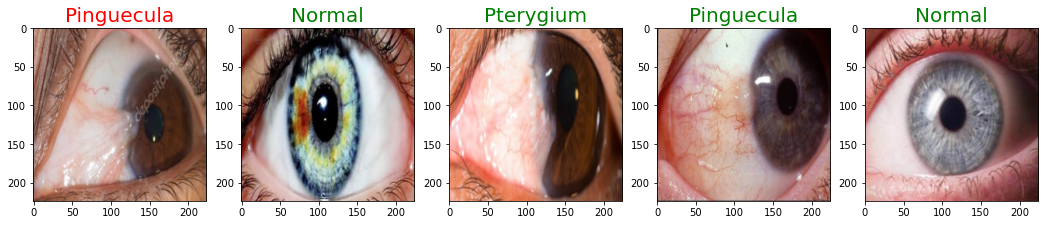

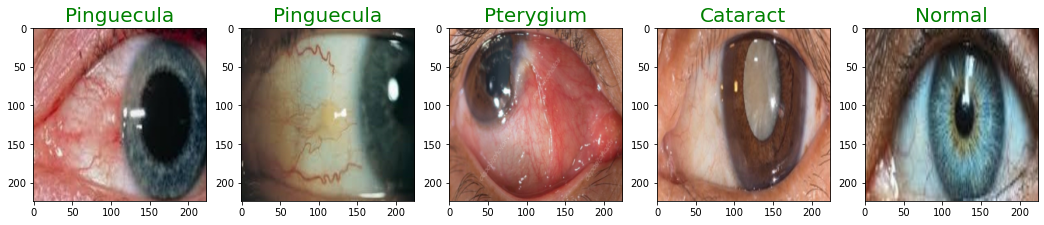

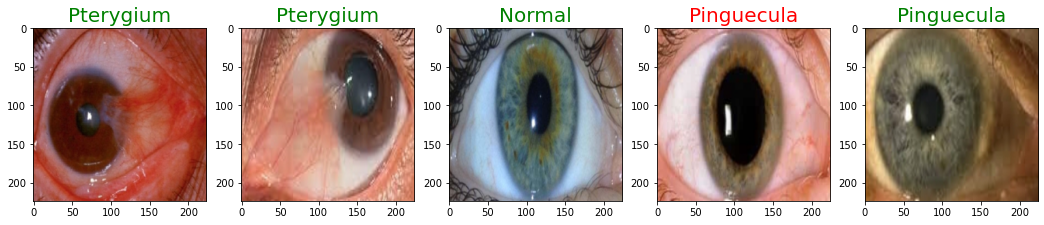

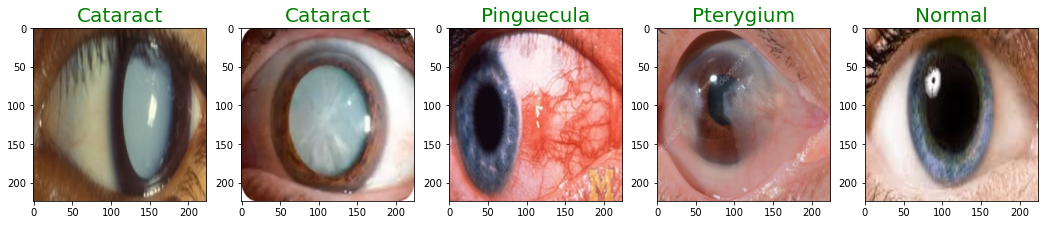

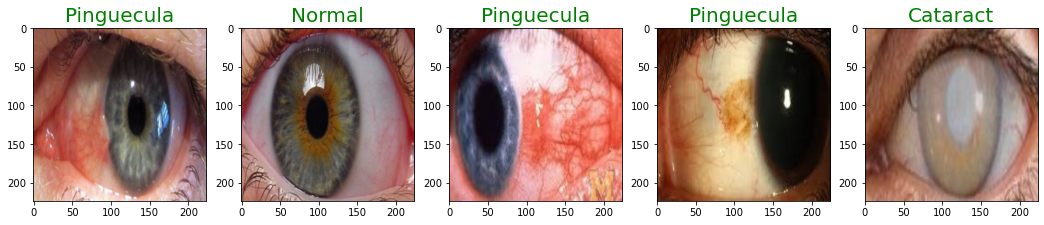

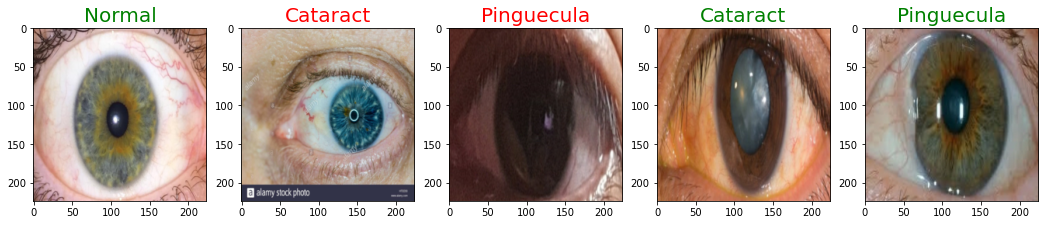

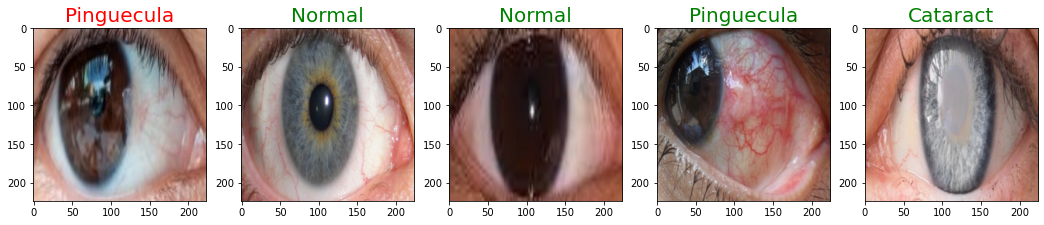

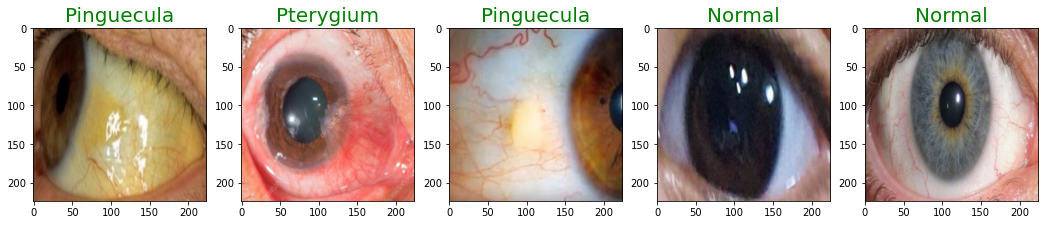

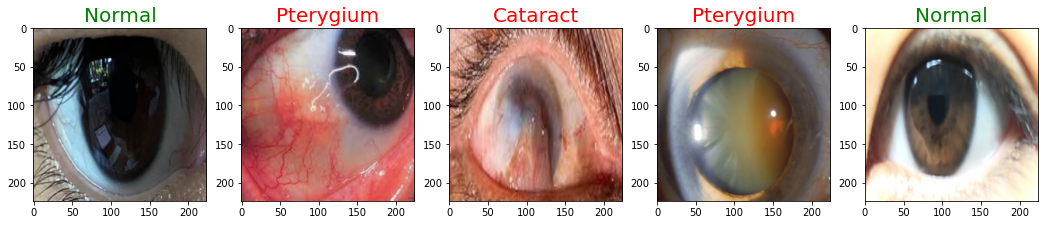

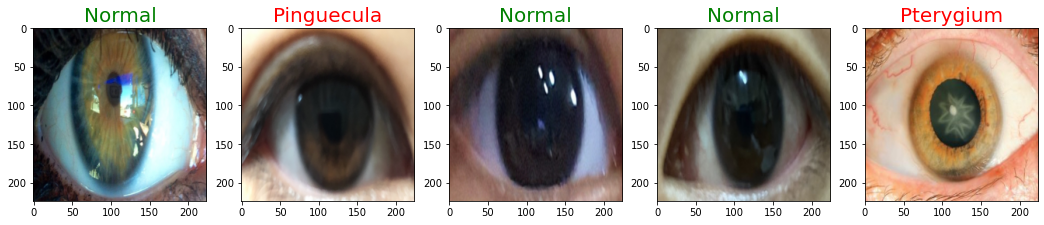

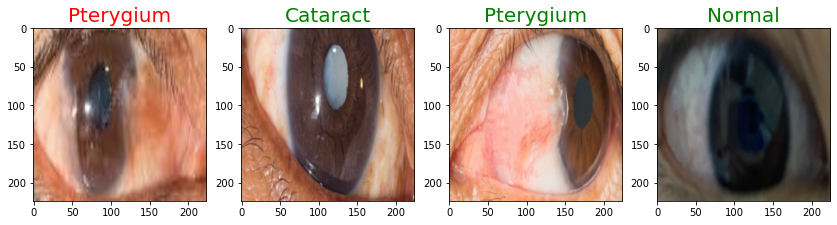

Accuracy : 0.80


In [8]:
y = predict(test, plot = True)